In [1]:
import utility_module_2_v_3 as uu
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy.ma as ma
from numpy import meshgrid
from mpl_toolkits.basemap import Basemap
from tqdm import tqdm

import geopandas as gpd
from shapely.geometry  import Point
from shapely.geometry import shape
import seaborn as sns


In [2]:
path_out_P = '/home/vikram/BCSD_data/' + 'US_P_BCSD/'
path_out_T = '/home/vikram/BCSD_data/' + 'US_T_BCSD/'

output_figname = ''#_eqm'

# Init

In [3]:
gcm_names=['MIROC_ESM','CanESM2','HadGEM_AO','GFDL_CM3']
gcm_name  =  gcm_names[1]

In [4]:
def getclosest_ij(lats,lons,latpt,lonpt):
    dis_sq1=(lats-latpt)**2
    dis_sq2=(lons-lonpt)**2
    
    minidex_lat=dis_sq1.argmin()
    minidex_lon=dis_sq2.argmin()
    
    return minidex_lon,minidex_lat

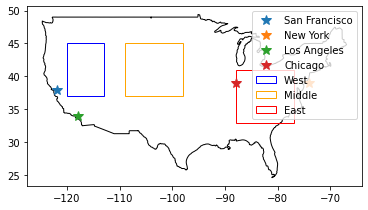

In [6]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import geopandas as gpd
from geopy.geocoders import Nominatim



lats,lons = (np.arange(0,40,1),np.arange(-180,100,1))
XX12,YY12 = np.meshgrid(lons,lats)
colors= ['blue','orange','red','green','purple','brown','pink','gray','olive','cyan','k']

fig, ax = plt.subplots()

for address in ['San Francisco','New York','Los Angeles', 'Chicago']:
    geolocator = Nominatim(user_agent="Your_Name")
    location = geolocator.geocode(address)
    [ind_lon,ind_lat] = getclosest_ij(lats,lons,location.latitude,location.longitude)
    plt.plot(lons[ind_lon],lats[ind_lat],marker='*',linestyle = 'none',markersize= 10,label = address)

ind = gpd.read_file('/home/vikram/BCSD_Shapefiles/Us_boundary.shp')
ind.plot(ax=ax,facecolor="none")

regional_boxes = [[-120,37,-113,45],
                  [-109,37,-98,45],
                  [-88,33,-77,41]]
regions  = [ 'West', 'Middle', 'East' ]
for citer,co_ords in enumerate(regional_boxes):
    ax.add_patch(Polygon([(co_ords[0],co_ords[1]),
                           (co_ords[0],co_ords[3]),
                           (co_ords[2],co_ords[3]),
                           (co_ords[2],co_ords[1])],facecolor='none',edgecolor= colors[citer],label =regions[citer]))

plt.legend()
plt.show()




In [7]:
def create_mask(fo,lat_obs_cru,lon_obs_cru,buffer=0,plot=0):
  filename=gpd.read_file(fo)
  shp_geom = shape(filename.geometry[0])

  xxc, yyc = meshgrid(lon_obs_cru,lat_obs_cru)
  mask_shape=np.zeros(xxc.shape,dtype=bool)
  if plot==1:
    x,y = shp_geom.exterior.xy
    plt.plot(x,y)
  N1=xxc.shape[0]
  N2=xxc.shape[1]

  for lat_i in range(0,N1):
    for lon_i in range(0,N2):
      xi=xxc[lat_i,lon_i]
      yi=yyc[lat_i,lon_i]
      m1= (shp_geom.contains(Point(xi, yi)) or shp_geom.touches(Point(xi, yi)))
      mask_shape[lat_i,lon_i]=not m1

  return mask_shape

In [8]:
def extract_regions(data_input,lat_obs,lon_obs):
    
    data_to_indices = []
    for address in ['San Francisco','New York','Los Angeles', 'Chicago']:
        geolocator = Nominatim(user_agent="Your_Name")
        location = geolocator.geocode(address)
        [ind_lon,ind_lat] = getclosest_ij(lat_obs.data,lon_obs.data,location.latitude%360,location.longitude%360)
        data_to_indices.append(data_input[:, ind_lat,ind_lon])


    regional_boxes = [[-120%360,45,-113%360,37],
                      [-109%360,45,-98%360,37],
                      [-88%360,41,-77%360,33]]
    
    
    for co_ords in regional_boxes:

        lat_index_123 = np.logical_and(lat_obs >= co_ords[3], lat_obs <= co_ords[1])
        lon_index_123 = np.logical_and(lon_obs >= co_ords[0], lon_obs <= co_ords[2])
        # print(lat_index_123.sum(), lon_index_123.sum())
        data_to_indices.append(np.nanmean(data_input[:, lat_index_123,:][:,:,lon_index_123],axis=(1,2)))

    data_to_indices.append(np.nanmean(data_input,axis=(1,2)))

    # print(data_to_indices[0].shape)
    data_out= {}
    data_out['Mean'] = []
    data_out['Var'] = []
    
    
    for data_iter in (data_to_indices):
        data_temp =  data_iter.reshape((12,-1),order ='F').sum(axis = 0)
        data_out['Mean'].append(np.mean(data_temp))
        data_out['Var'].append(np.var(data_temp))
        
    return data_out


# Import data

In [12]:

metadata=np.load(path_out_P+ '/pre_metadata'+gcm_name+'.npy', allow_pickle=True)
st=metadata.item()['st']
en=metadata.item()['en']

mask_fine_obs=metadata.item()['mask']

lat_obs=metadata.item()['lat_obs']
lon_obs=metadata.item()['lon_obs']

N_random = 10
gcm_list = ['GFDL_CM3','CanESM2','MIROC_ESM','MRI_ESM1','ACCESS1_0','NorESM1_M','CM5A_LR','CNRM_CM5','MPI_ESM_MR']
N_esms = len(gcm_list)
tas_obs=np.load(path_out_T+ '/tas_obs.npy')
tas_data_all=np.empty([1+N_esms *4,tas_obs.shape[0],tas_obs.shape[1],tas_obs.shape[2]])
pre_obs=np.load(path_out_P+ '/pre_obs.npy')
pre_data_all=np.empty([1+N_esms * 4 +N_random,pre_obs.shape[0],pre_obs.shape[1],pre_obs.shape[2]])


tas_data_all[0]=tas_obs
pre_data_all[0]=pre_obs

for giter,gcm_name in tqdm(enumerate(gcm_list)):
#     tas_data_all[1+giter]=np.load(path_out_T+ '/tas_gcm_fine_'+gcm_name+'.npy')
#     tas_data_all[1+giter +N_esms]=np.load(path_out_T+ '/detrended_BCSD_outputs_historical_tas_'+gcm_name+'_cru.npy')
    
#     tas_gcm=np.load(path_out_T+ '/tas_gcm_future_'+gcm_name+'.npy')
#     metadata=np.load(path_out_P+ '/pre_metadata'+gcm_name+'.npy', allow_pickle=True)
    
#     lat_gcm=metadata.item()['lat_gcm']
#     lon_gcm=metadata.item()['lon_gcm']
   
#     tas_gcm_fine=np.zeros((tas_gcm.shape[0],tas_obs.shape[1],tas_obs.shape[2]))
    
#     for i in range(tas_gcm.shape[0]):
#         tas_gcm_fine[i,:,:]=uu.regrid(tas_gcm[i,:,:],lat_gcm,lon_gcm,lat_obs,lon_obs)
        

#     tas_data_all[1+giter + 2* N_esms]        = np.concatenate((tas_gcm_fine  , np.nan * np.zeros((120 ,tas_obs.shape[1],tas_obs.shape[2]))),axis = 0)
#     temp_123 =(np.load(path_out_T+ '/detrended_BCSD_outputs_tas_'+gcm_name+'_cru.npy'))
#     tas_data_all[1+giter + 3* N_esms] = np.concatenate((temp_123  ,
#                                                    np.nan * np.zeros((120 ,tas_obs.shape[1],tas_obs.shape[2]))),axis = 0)
      
    
    
    
    pre_data_all[1 + giter ]=np.load(path_out_P+ '/pre_gcm_fine'+gcm_name+'.npy')
    pre_data_all[1 + giter +N_esms]=np.load(path_out_P+ '/detrended_BCSD_outputs_historical_pre_'+gcm_name+'_cru.npy')
    
    pre_gcm=np.load(path_out_P+ '/pre_gcm_future_'+gcm_name+'.npy')
    metadata=np.load(path_out_P+ '/pre_metadata'+gcm_name+'.npy', allow_pickle=True)
    
    lat_gcm=metadata.item()['lat_gcm']
    lon_gcm=metadata.item()['lon_gcm']
   
    pre_gcm_fine=np.zeros((pre_gcm.shape[0],pre_obs.shape[1],pre_obs.shape[2]))

    for i in range(pre_gcm.shape[0]):
        pre_gcm_fine[i,:,:]=uu.regrid(pre_gcm[i,:,:],lat_gcm,lon_gcm,lat_obs,lon_obs)
        
    pre_data_all[1 + giter + 2 * N_esms ]= np.concatenate((pre_gcm_fine  , np.nan * np.zeros((120 ,pre_obs.shape[1],pre_obs.shape[2]))),axis = 0)
    pre_data_all[1 + giter  + 3 * N_esms]= np.concatenate((uu.correct_nan_inf_neg(np.load(path_out_P+ '/detrended_BCSD_outputs_pre_'+gcm_name+'_cru.npy')[105*12:,:,:])  ,
                                                    np.nan * np.zeros((120 ,pre_obs.shape[1],pre_obs.shape[2]))),axis = 0)
for riter in range(10):
    pre_data_all[1 + riter  + 4 * N_esms]= uu.correct_nan_inf_neg(np.load(path_out_P+ '/BCSD_outputs_pre_rnd_new2_'+str(riter+1) + '_cru.npy'))
                                    


9it [00:18,  2.07s/it]


In [13]:
ind = gpd.read_file('/home/vikram/BCSD_Shapefiles/Us_boundary.shp')
ind.plot(ax=ax,facecolor="none")
mask_usf=create_mask('/home/vikram/BCSD_Shapefiles/us_rough.shp',lat_obs.data,lon_obs.data-360,buffer=1,plot=0)



<Figure size 432x288 with 0 Axes>

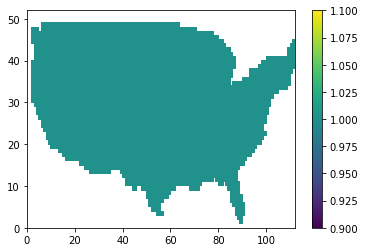

In [14]:
mask_usf_int = np.array(mask_usf,dtype= np.float16)
mask_usf_int[mask_usf == True] = np.nan
mask_usf_int[mask_usf == False] = 1
plt.pcolor(mask_usf_int)
plt.colorbar()

In [15]:
data_mean_all = []
data_var_all = []
for diter in tqdm(range(1+N_esms*4  + N_random)):
    dataset =pre_data_all[diter]
    data_mean_all.append(extract_regions(dataset[45*12:-120,:,:],lat_obs,lon_obs)['Mean'])
    data_var_all.append(extract_regions(dataset[45*12:-120,:,:],lat_obs,lon_obs)['Var'])


100%|███████████████████████████████████████████| 47/47 [03:08<00:00,  4.02s/it]


/tmp/ipykernel_590920/4075728597.py:54: RuntimeWarning: Mean of empty slice
  plt.pcolor(lon_obs,lat_obs,np.nanmean(dat_annual,axis=0)*mask_usf_int,cmap = 'RdYlGn_r',


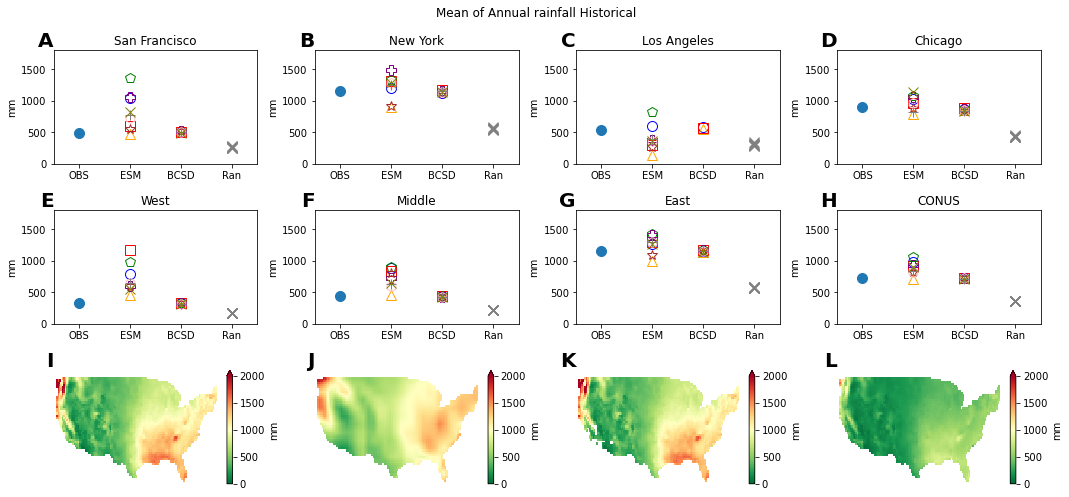

In [18]:
lxx,lyy = 0,1

plt.figure(figsize = (15,7))

N_esm =len(gcm_list)
N_random = 10
    
markers=['o','^','s','p','P','*','h','+','x','X','D']

data_to_indices_label = ['San Francisco','New York','Los Angeles', 'Chicago', 'West', 'Middle', 'East' ,"CONUS"]
# path_out = "/home/vikram/Dropbox/BCSD Work/03_Figures/plots_Oct10/"

for pliter in range(8):
    ax = plt.subplot(3,4,pliter +1)
    plt.plot( 1, data_mean_all[0][pliter],
         markers[0],markersize = 10,linestyle = 'None',label = "Obs")

        
    for gi in range(N_esm):
        
    
        plt.plot( 2 , data_mean_all[1+gi][pliter],
                 markers[gi],color = colors[gi],markersize = 10,linestyle = 'None',mfc='none',label = gcm_list[gi])

        plt.plot( 3 , data_mean_all[1+gi+N_esm][pliter],
                 markers[gi],color = colors[gi],markersize = 10,linestyle = 'None',mfc='none',label = gcm_list[gi])
        
    for ri in range(N_random):            
        plt.plot( 4 , data_mean_all[1+ri+N_esm*4][pliter],
                 'x',color = 'gray' , markersize = 10,linestyle = 'None',mfc='none',label = gcm_list[gi])
                
    
    plt.ylim([0,1800])
    plt.xticks(range(1,5),["OBS","ESM","BCSD","Ran"],rotation = 0 )
    plt.title(data_to_indices_label[pliter])
    
    plt.xlim([0.5,4.5])
    plt.ylabel("mm")
    plt.text(lxx, lyy, chr(65+pliter), horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
    fontsize=20,color='k')

indices_pre_data = [0,
                    1 + giter + 0 * N_esms,
                    1 + giter  + 1 * N_esms,
                    1 + giter  + 4 * N_esms,]

for pliter in range(4):

    
    ax =plt.subplot(3,4,8+pliter+1)
    dat_monthly = pre_data_all[indices_pre_data[pliter]].reshape((12,-1,52,112),order ='F')
    dat_annual = np.sum(dat_monthly,axis = 0)

    plt.pcolor(lon_obs,lat_obs,np.nanmean(dat_annual,axis=0)*mask_usf_int,cmap = 'RdYlGn_r',
      vmax= 2000,vmin = 0)
    plt.colorbar(extend = 'max', label = "mm")
    plt.axis('off')
    lxx,lyy = 0,1
    plt.text(lxx, lyy, chr(65+8+pliter), horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
        fontsize=20,color='k')
plt.suptitle("Mean of Annual rainfall Historical")
    
plt.tight_layout()
plt.savefig( "P_ann_us_hist.png", dpi =150, facecolor = 'w')


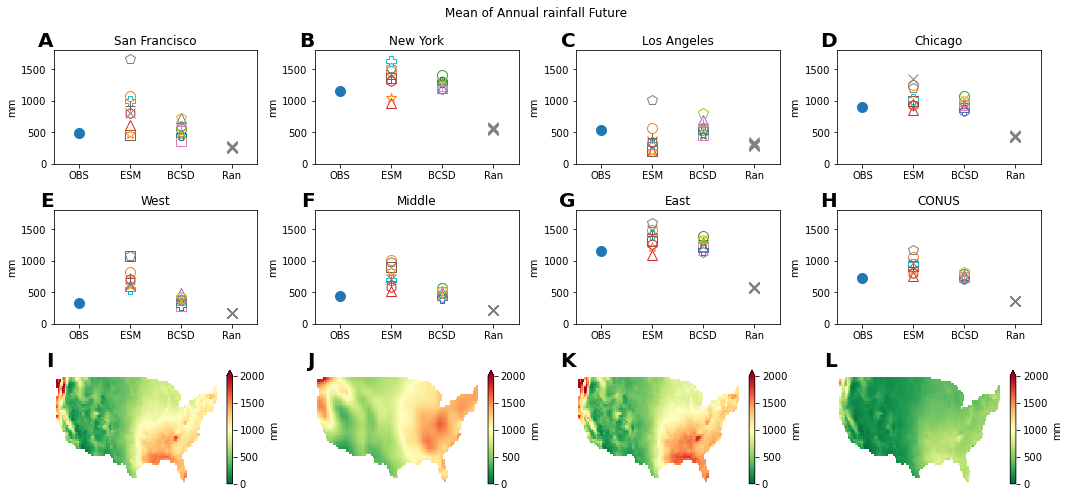

In [21]:
lxx,lyy = 0,1

plt.figure(figsize = (15,7))

N_esm =len(gcm_list)
N_random = 10
    
markers=['o','^','s','p','P','*','h','+','x','X','D']
colors= ['blue','orange','red','green','purple','brown','pink','gray','olive','cyan','k']

data_to_indices_label = ['San Francisco','New York','Los Angeles', 'Chicago', 'West', 'Middle', 'East' ,"CONUS"]
# path_out = "/home/vikram/Dropbox/BCSD Work/03_Figures/plots_Oct10/"

for pliter in range(8):
    ax = plt.subplot(3,4,pliter +1)
    plt.plot( 1, data_mean_all[0][pliter],
         markers[0],markersize = 10,linestyle = 'None',label = "Obs")

        
    for gi in range(N_esm):
        
    
        plt.plot( 2 , data_mean_all[1+gi+N_esm*2][pliter],
                 markers[gi],markersize = 10,linestyle = 'None',mfc='none')
        
        plt.plot( 3 , data_mean_all[1+gi+N_esm*3][pliter],
                 markers[gi],markersize = 10,linestyle = 'None',mfc='none',label = gcm_list[gi])
        
        
    for ri in range(N_random):            
        plt.plot( 4 , data_mean_all[1+ri+N_esm*4][pliter],
                 'x',color = 'gray' , markersize = 10,linestyle = 'None',mfc='none',label = gcm_list[gi])
                
    
    plt.ylim([0,1800])
    plt.xticks(range(1,5),["OBS","ESM","BCSD","Ran"],rotation = 0 )
    plt.title(data_to_indices_label[pliter])
    
    plt.xlim([0.5,4.5])
    plt.ylabel("mm")
    plt.text(lxx, lyy, chr(65+pliter), horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
    fontsize=20,color='k')


indices_pre_data = [0,
                    1 + giter + 2 * N_esms,
                    1 + giter  + 3 * N_esms,
                    1 + giter  + 4 * N_esms,]

for pliter in range(4):

    
    ax =plt.subplot(3,4,8+pliter+1)
    dat_monthly = pre_data_all[indices_pre_data[pliter]].reshape((12,-1,52,112),order ='F')
    dat_annual = np.sum(dat_monthly,axis = 0)

    plt.pcolor(lon_obs,lat_obs,np.nanmean(dat_annual,axis=0)*mask_usf_int,cmap = 'RdYlGn_r',
      vmax= 2000,vmin = 0)
    plt.colorbar(extend =  'max', label = "mm")
    plt.axis('off')
    lxx,lyy = 0,1
    plt.text(lxx, lyy, chr(65+8+pliter), horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
        fontsize=20,color='k')
plt.suptitle("Mean of Annual rainfall Future")
    
plt.tight_layout()
plt.savefig( "P_ann_us_future.png", dpi =150, facecolor = 'w')


## IAV

/tmp/ipykernel_590920/3003750305.py:55: RuntimeWarning: Degrees of freedom <= 0 for slice.
  plt.pcolor(lon_obs,lat_obs,np.nanvar(dat_annual,axis=0)*mask_usf_int/10000,cmap = 'RdYlGn_r',


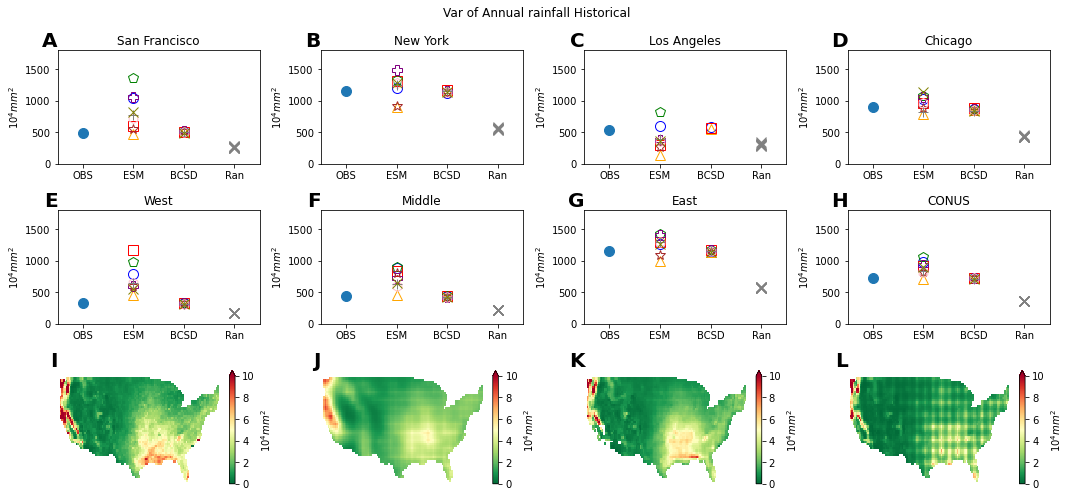

In [23]:
lxx,lyy = 0,1

plt.figure(figsize = (15,7))

N_esm =len(gcm_list)
N_random = 10
    
markers=['o','^','s','p','P','*','h','+','x','X','D']
colors= ['blue','orange','red','green','purple','brown','pink','gray','olive','cyan','k']

data_to_indices_label = ['San Francisco','New York','Los Angeles', 'Chicago', 'West', 'Middle', 'East' ,"CONUS"]
# path_out = "/home/vikram/Dropbox/BCSD Work/03_Figures/plots_Oct10/"

for pliter in range(8):
    ax = plt.subplot(3,4,pliter +1)
    plt.plot( 1, data_mean_all[0][pliter],
         markers[0],markersize = 10,linestyle = 'None',label = "Obs")

        
    for gi in range(N_esm):
        
    
        plt.plot( 2 , data_mean_all[1+gi][pliter],
                 markers[gi],color = colors[gi],markersize = 10,linestyle = 'None',mfc='none',label = gcm_list[gi])

        plt.plot( 3 , data_mean_all[1+gi+N_esm][pliter],
                 markers[gi],color = colors[gi],markersize = 10,linestyle = 'None',mfc='none',label = gcm_list[gi])
        
    for ri in range(N_random):            
        plt.plot( 4 , data_mean_all[1+ri+N_esm*4][pliter],
                 'x',color = 'gray' , markersize = 10,linestyle = 'None',mfc='none',label = gcm_list[gi])
                
    
    plt.ylim([0,1800])
    plt.xticks(range(1,5),["OBS","ESM","BCSD","Ran"],rotation = 0 )
    plt.title(data_to_indices_label[pliter])
    
    plt.xlim([0.5,4.5])
    plt.ylabel("$10^4 mm^2$")
    plt.text(lxx, lyy, chr(65+pliter), horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
    fontsize=20,color='k')

indices_pre_data = [0,
                    1 + giter + 0 * N_esms,
                    1 + giter  + 1 * N_esms,
                    1 + giter  + 4 * N_esms,]

for pliter in range(4):

    
    ax =plt.subplot(3,4,8+pliter+1)
    dat_monthly = pre_data_all[indices_pre_data[pliter]].reshape((12,-1,52,112),order ='F')
    dat_annual = np.sum(dat_monthly,axis = 0)

    plt.pcolor(lon_obs,lat_obs,np.nanvar(dat_annual,axis=0)*mask_usf_int/10000,cmap = 'RdYlGn_r',
      vmax= 10,vmin = 0)
    plt.colorbar(extend = 'max', label ="$10^4 mm^2$")
    plt.axis('off')
    lxx,lyy = 0,1
    plt.text(lxx, lyy, chr(65+8+pliter), horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
        fontsize=20,color='k')
plt.suptitle("Var of Annual rainfall Historical")
    
plt.tight_layout()
plt.savefig( "P_ann_IAV_us_hist.png", dpi =150, facecolor = 'w')


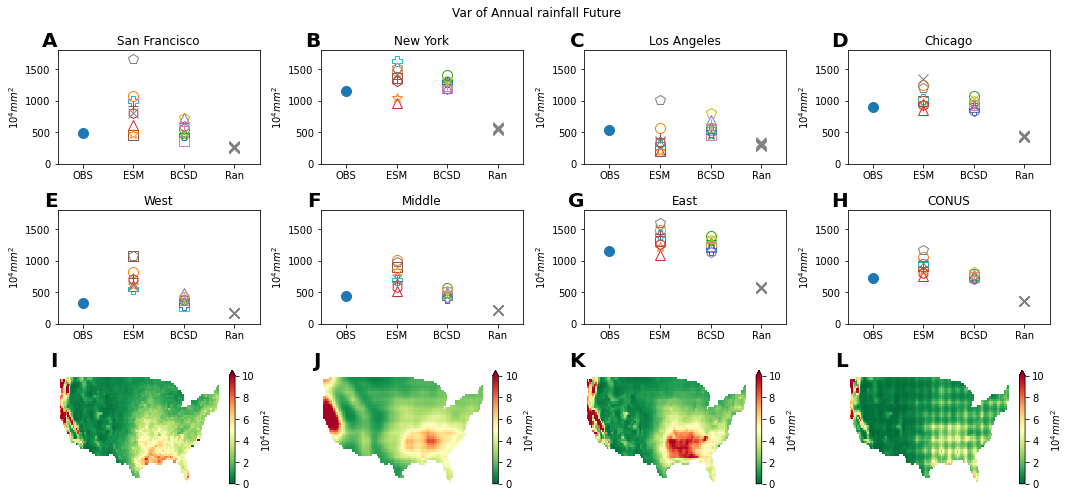

In [24]:
lxx,lyy = 0,1

plt.figure(figsize = (15,7))

N_esm =len(gcm_list)
N_random = 10
    
markers=['o','^','s','p','P','*','h','+','x','X','D']
colors= ['blue','orange','red','green','purple','brown','pink','gray','olive','cyan','k']

data_to_indices_label = ['San Francisco','New York','Los Angeles', 'Chicago', 'West', 'Middle', 'East' ,"CONUS"]
# path_out = "/home/vikram/Dropbox/BCSD Work/03_Figures/plots_Oct10/"

for pliter in range(8):
    ax = plt.subplot(3,4,pliter +1)
    plt.plot( 1, data_mean_all[0][pliter],
         markers[0],markersize = 10,linestyle = 'None',label = "Obs")

        
    for gi in range(N_esm):
        
    
        plt.plot( 2 , data_mean_all[1+gi+N_esm*2][pliter],
                 markers[gi],markersize = 10,linestyle = 'None',mfc='none')
        
        plt.plot( 3 , data_mean_all[1+gi+N_esm*3][pliter],
                 markers[gi],markersize = 10,linestyle = 'None',mfc='none',label = gcm_list[gi])
        
        
    for ri in range(N_random):            
        plt.plot( 4 , data_mean_all[1+ri+N_esm*4][pliter],
                 'x',color = 'gray' , markersize = 10,linestyle = 'None',mfc='none',label = gcm_list[gi])
                
    
    plt.ylim([0,1800])
    plt.xticks(range(1,5),["OBS","ESM","BCSD","Ran"],rotation = 0 )
    plt.title(data_to_indices_label[pliter])
    
    plt.xlim([0.5,4.5])
    plt.ylabel("$10^4 mm^2$")
    plt.text(lxx, lyy, chr(65+pliter), horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
    fontsize=20,color='k')


indices_pre_data = [0,
                    1 + giter + 2 * N_esms,
                    1 + giter  + 3 * N_esms,
                    1 + giter  + 4 * N_esms,]

for pliter in range(4):

    
    ax =plt.subplot(3,4,8+pliter+1)
    dat_monthly = pre_data_all[indices_pre_data[pliter]].reshape((12,-1,52,112),order ='F')
    dat_annual = np.sum(dat_monthly,axis = 0)

    plt.pcolor(lon_obs,lat_obs,np.nanvar(dat_annual,axis=0)*mask_usf_int/10000,cmap = 'RdYlGn_r',
      vmax= 10,vmin = 0)
    plt.colorbar(extend = 'max',label ="$10^4 mm^2$")
    plt.axis('off')
    lxx,lyy = 0,1
    plt.text(lxx, lyy, chr(65+8+pliter), horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
        fontsize=20,color='k')
plt.suptitle("Var of Annual rainfall Future")
    
plt.tight_layout()
plt.savefig( "P_ann_IAV_us_future.png", dpi =150, facecolor = 'w')


# Other 

In [ ]:
plt.figure(figsize =(15,20))

ax = plt.subplot(N_esms+1,4,1)
dat_monthly = pre_data_all[0].reshape((12,-1,52,112),order ='F')
dat_annual = np.sum(dat_monthly,axis = 0)

plt.pcolor(lon_obs,lat_obs,np.mean(dat_annual,axis=0)*mask_usf_int,cmap = 'BrBG',
          vmax= 2000,vmin = 0)
plt.colorbar()
plt.text(0.995, 0.995, "Observation", horizontalalignment='right',verticalalignment='top', transform=ax.transAxes,fontweight='bold',
       fontsize=18,color='k')

siter=0
for nrow in range(4):
    for ncol  in range(N_esms):#col is reaally a row xd
        
        itr =  nrow + ncol*4 + 1
        
        ax =plt.subplot(N_esms +1,4,4+itr)
        
        siter=siter+1
        
        
        dat_monthly = pre_data_all[siter].reshape((12,-1,52,112),order ='F')
        dat_annual = np.sum(dat_monthly,axis = 0)
        
        plt.pcolor(lon_obs,lat_obs,np.nanmean(dat_annual,axis=0)*mask_usf_int,cmap = 'BrBG',
          vmax= 2000,vmin = 0)
        plt.colorbar()
        # break
          
        plt.text(0.995, 0.995, gcm_list[ncol], horizontalalignment='right',verticalalignment='top', transform=ax.transAxes,fontweight='bold',
               fontsize=18,color='k')
        
        
plt.suptitle("Mean of Annual rainfall")
plt.tight_layout()## change to monthly
## plot mean and Inter annual variability
# plt.savefig(path_out +  "map_mean_us.png", dpi =150, facecolor = 'w')


In [ ]:
plt.figure(figsize =(15,20))

ax = plt.subplot(N_esms+1,4,1)
dat_monthly = pre_data_all[0].reshape((12,-1,52,112),order ='F')
dat_annual = np.sum(dat_monthly,axis = 0)

plt.pcolor(lon_obs,lat_obs,np.nanvar(dat_annual,axis=0)*mask_usf_int/10000,cmap = 'RdYlBu_r',
          vmax= 10,vmin = 0)
plt.colorbar()
plt.text(0.995, 0.995, "Observation", horizontalalignment='right',verticalalignment='top', transform=ax.transAxes,fontweight='bold',
       fontsize=18,color='k')

siter=0
for nrow in range(4):
    for ncol  in range(N_esms):#col is reaally a row xd
        
        itr =  nrow + ncol*4 + 1
        
        ax =plt.subplot(N_esms +1,4,4+itr)
        
        siter=siter+1
        
        
        dat_monthly = pre_data_all[siter].reshape((12,-1,52,112),order ='F')
        dat_annual = np.sum(dat_monthly,axis = 0)
        
        plt.pcolor(lon_obs,lat_obs,np.nanvar(dat_annual,axis=0)*mask_usf_int/10000,cmap = 'RdYlBu_r',
          vmax= 10,vmin = 0)
        plt.colorbar()
        # break
          
        plt.text(0.995, 0.995, gcm_list[ncol], horizontalalignment='right',verticalalignment='top', transform=ax.transAxes,fontweight='bold',
               fontsize=18,color='k')
        
        
plt.suptitle("IAV of Annual rainfall")
plt.tight_layout()## change to monthly
## plot mean and Inter annual variability
# plt.savefig(path_out +  "map_var_us.png", dpi =150, facecolor = 'w')
